# Day 5: Nonlinear Least Squares (NLS)

---

- Example
- Math formulation
- Grama tools


In [1]:
import grama as gr

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


## Example: Fitting a trajectory

---

Let's look at some "data" of a penny falling from the Empire State Building.


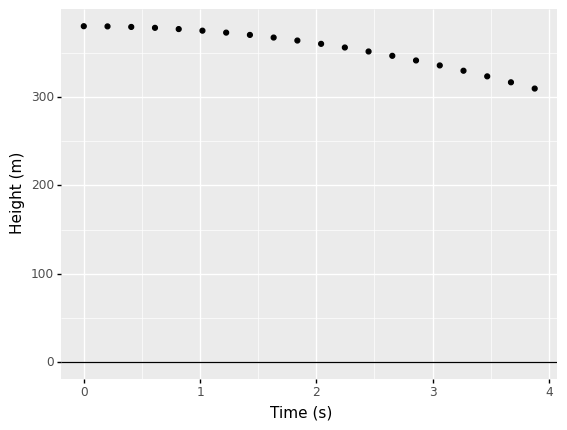

<ggplot: (8774017715987)>

In [2]:
df_penny = pd.read_csv("./data/penny.csv")

(
    df_penny
    >> ggplot(aes("t", "y"))
    + geom_point()
    + geom_hline(yintercept=0)
    + labs(
        x="Time (s)",
        y="Height (m)"
    )
)


### Model for projectile motion

Assume [Stokes drag](https://en.wikipedia.org/wiki/Projectile_motion#Displacement):

$$y(t) = y_0 - (g \tau) t + \tau (v_0 + g \tau) (1 - \exp(-t/\tau))$$

Implement as a Grama model:


In [3]:
g = 9.8 # Acceleration due to gravity
y0 = 380 # Height of empire state building
v0 = 0   # Initial velocity

md_penny = (
    gr.Model("Penny")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=y0 - g * df.tau * df.t + df.tau * (v0 + g * df.tau) * (1 - np.exp(-df.t / df.tau))
        ),
        var=["t", "tau"],
        out=["y"]
    )
    >> gr.cp_bounds(
        tau=(0, 100), # Time constant unknown
    )
)

md_penny.printpretty()


model: Penny

  inputs:
    var_det:
      tau: [0, 100]
      t: (unbounded)
    var_rand:
    copula:
        None
  functions:
    f0: ['t', 'tau'] -> ['y']


We don't know the quantity `tau`, but we have data: Use NLS to fit `tau`.


In [4]:
df_tau = gr.eval_nls(
    md_penny,
    df_data=df_penny,
)
df_tau

... eval_nls setting out = ['y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']


,tau
0,29.119542


Use this fitted value to evaluate the model and make a prediction


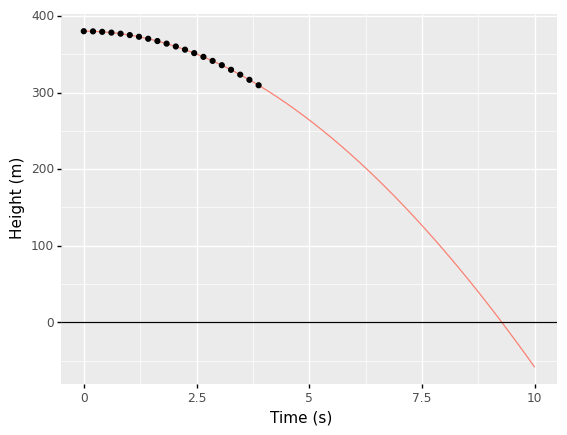

<ggplot: (8774011286429)>

In [5]:
df_predict = (
    md_penny
    >> gr.ev_df(
        df=gr.df_make(t=np.linspace(0, 10))
        >> gr.tf_outer(df_tau)
    )
)

(
    df_penny
    >> ggplot(aes("t", "y"))
    + geom_line(data=df_predict, color="salmon")
    + geom_point()
    + geom_hline(yintercept=0)
    + labs(
        x="Time (s)",
        y="Height (m)"
    )
)


## Math Formulation

---

We have some function $f(x; \theta)$ that we want to use to make predictions on observed values $y_i$. We *believe* that $y = f(x; \theta) + \epsilon$ is a good model for the observed values, where $x$ are measured variables, $\theta$ are unknown parameters, and $\epsilon$ represent mismatch between the model and measured values.

| Quantity | Meaning |
|---|---|
| $y$ | Measured values |
| $x$ | Measured variables |
| $\theta$ | Unknown parameters |
| $\epsilon$ | Errors |
| $f(x; \theta)$ | Model function |

In the penny problem:

| Quantity | Penny Example |
|---|---|
| $y$ | Measured height $y$ |
| $x$ | Measured time $t$ |
| $\theta$ | Time constant $\tau$ |
| $f(x; \theta)$ | Trajectory model |

We could manually try different parameter $\theta$ values:


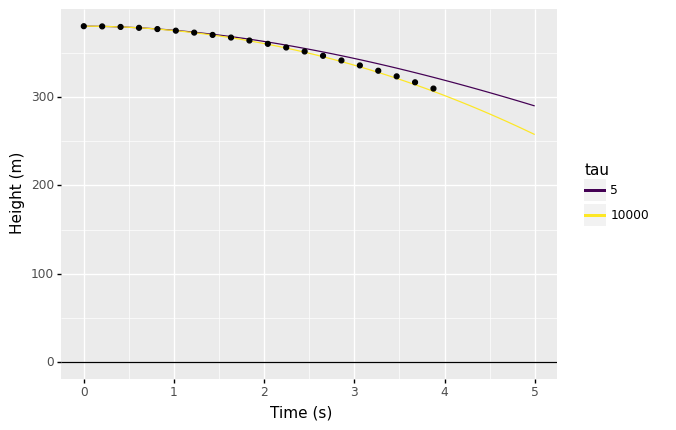

<ggplot: (8774011273611)>

In [6]:
df_try = (
    md_penny
    >> gr.ev_df(
        df=gr.df_make(t=np.linspace(0, 5))
        >> gr.tf_outer(gr.df_make(tau=[5, 1e4]))
    )
    >> gr.tf_mutate(tau=gr.as_factor(DF.tau))
)

(
    df_penny
    >> ggplot(aes("t", "y"))
    + geom_line(data=df_try, mapping=aes(color="tau", group="tau"))
    + geom_point()
    + geom_hline(yintercept=0)
    + labs(
        x="Time (s)",
        y="Height (m)"
    )
)


### Goodness of Fit

The mean squared error (MSE) is a measure of goodness of fit of the model $f(x; \theta)$.

$$MSE(\theta) = \frac{1}{n} \sum_{i=1}^n (y_i - f(x_i; \theta))^2$$


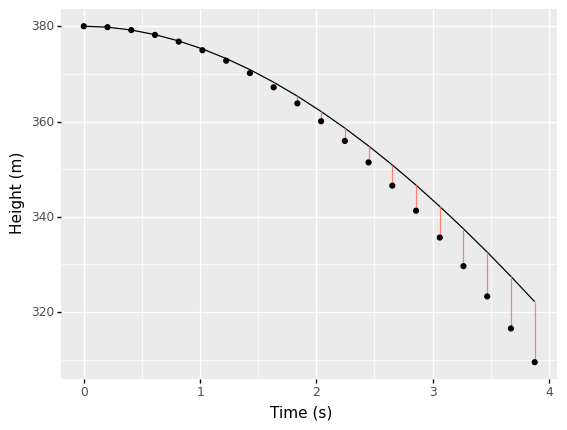

<ggplot: (8774011234350)>

In [7]:
df_penny_error = (
    md_penny
    >> gr.ev_df(
        df=df_penny
        >> gr.tf_rename(y_meas=DF.y)
        >> gr.tf_outer(gr.df_make(tau=5))
    )
)

(
    df_penny
    >> ggplot(aes("t", "y"))
    + geom_line(data=df_penny_error)
    + geom_segment(
        data=df_penny_error,
        mapping=aes(xend="t", yend="y_meas"),
        color="salmon"
    )
    + geom_point()
    + labs(
        x="Time (s)",
        y="Height (m)"
    )
)


The red segments are the *residuals* $r_i = y_i - f(x_i; \theta)$. Squaring the residuals $r_i$ and taking their mean gives the mean squared error.

We can find $\theta$ by an optimization problem

$$\min\, MSE(\theta)$$
$$\text{wrt.}\, \theta$$


### Linear vs Nonlinear Least Squares

If $f$ is *linear* in its parameters $\theta$, the optimization problem has a unique solution. For instance, consider

$$f(x; \theta) = \theta_0 + x \theta_1 + x^2 \theta_2$$

This is *nonlinear* in $x$, but *linear* in $\theta$.

If $f$ is *nonlinear* in its parameters $\theta$, the optimization problem does not *necessarily* have a unique solution. Let's look at a really simple case:

$$f(\theta) = 1 - \theta^2$$

If we have $y = 1$, then $\theta^* = \pm 1$.


### Frequency example

Remember with signals that the sampling rate can cause [aliasing](https://en.wikipedia.org/wiki/Aliasing), causing multiple frequencies to appear identical. The following sinusoids illustrate the problem:


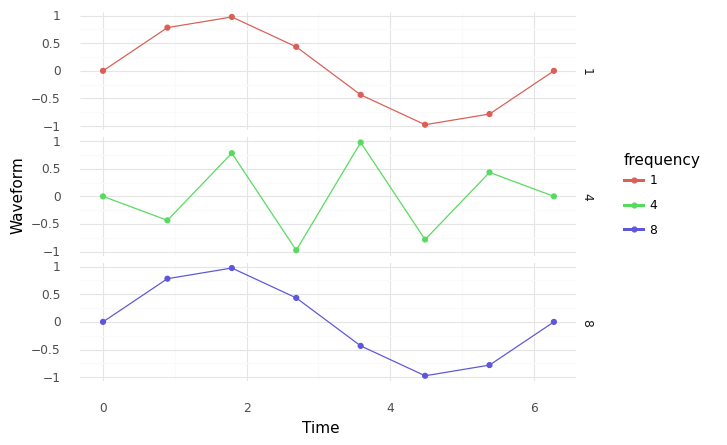

<ggplot: (8774011165669)>

In [8]:
df_waveform = (
    gr.df_make(t=np.linspace(0, 2 * np.pi, num=8))
    >> gr.tf_mutate(
        y1=gr.sin(1 * DF.t),
        y4=gr.sin(4 * DF.t),
        y8=gr.sin(8 * DF.t),
    )
    >> gr.tf_gather("frequency", "y", ["y1", "y4", "y8"])
    >> gr.tf_mutate(frequency=gr.str_extract(DF.frequency, "\\d+"))
)

(
    df_waveform
    >> ggplot(aes("t", "y", color="frequency"))
    + geom_line()
    + geom_point()
    + facet_grid("frequency~.")
    + theme_minimal()
    + labs(x="Time", y="Waveform")
)


The waveforms with `frequency==1` and `frequency==8` appear identical. We can't distinguish between $\theta = 1$ and $\theta = 8$ for this model.


## Grama Routines

---

Let's go through another example of fitting with Grama tools with trajectory data.


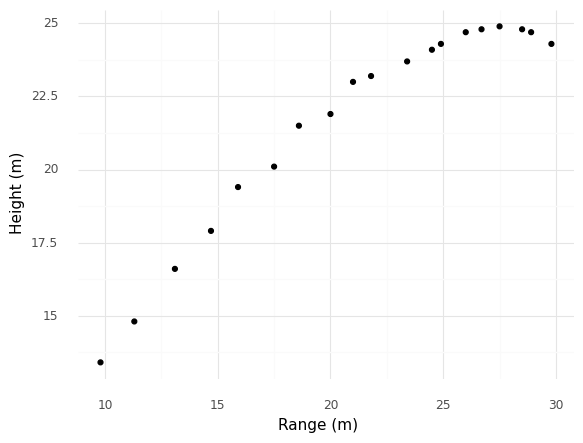

<ggplot: (8774011237416)>

In [9]:
from grama.data import df_trajectory_windowed

(
    df_trajectory_windowed
    >> ggplot(aes("x", "y"))
    + geom_point()
    + theme_minimal()
    + labs(x="Range (m)", y="Height (m)")
)


In [10]:
from grama.models import make_trajectory_linear

md_traj = make_trajectory_linear()
md_traj.printpretty()


model: Trajectory Model

  inputs:
    var_det:
      v0: [0.1, inf]
      tau: [0.05, inf]
      t: [0, 600]
      u0: [0.1, inf]
    var_rand:
    copula:
        None
  functions:
    x_trajectory: ['u0', 'v0', 'tau', 't'] -> ['x']
    y_trajectory: ['u0', 'v0', 'tau', 't'] -> ['y']


The routine `gr.ft_nls()` is a `fit` function: It takes a dataset and returns a Grama model. The resulting model is "fitted"; the free parameter values are determined by optimizing the MSE and fixed to optimal values. The `gr.ft_nls()` routine will automatically print fitting diagnostics to the console; these can help determine whether the fitting procedure was successful.


In [11]:
md_traj_fit0 = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_traj,
    )
)
md_traj_fit0.printpretty()


... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
           v0   tau          u0  v0_0  tau_0  u0_0  success  \
0  447.996569  0.05  425.161431   0.1   0.05   0.1     True   

                                             message  n_iter       mse  
0  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...       3  25.49725  
model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)
    var_rand:
    copula:
        None
  functions:
    Fix variable levels: ['t'] -> ['v0', 'tau', 'u0']
    Trajectory Model: ['tau', 't', 'u0', 'v0'] -> ['y', 'x']


The diagnostics report both the fitted parameter values `var` and their initial guesses `var_0`. We can see that `success==True`, indicating that the *optimization* routine successfully arrived at a local minimum.

However, it's not clear whether this is a "good" or "bad" fit, based solely on the optimized `mse` value. It's better to do a visual inspection of the model fit.


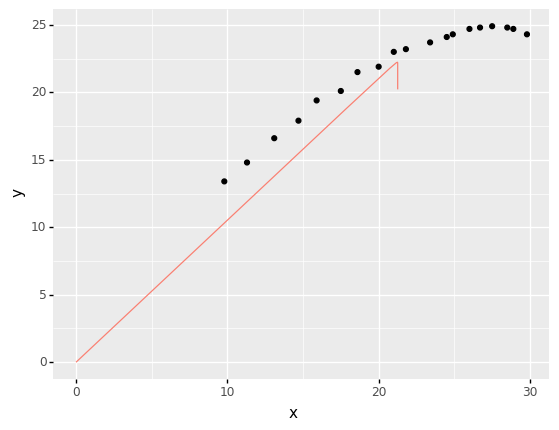

<ggplot: (8774011235759)>

In [12]:
df_traj_fit0 = gr.eval_df(
    md_traj_fit0,
    df=gr.df_make(t=np.linspace(0, 4.5))
)

(
    df_traj_fit0
    >> ggplot(aes("x", "y"))
    + geom_line(color="salmon")
    + geom_point(data=df_trajectory_windowed)
)


It's pretty clear that something fishy is happening with this fitted trajectory; the trajectory looks like a straight line from the starting point towards the middle of the data. Looking at the optimized parameters, we can see the initial velocity is *way* too large, on the order of $400 m/s$. We can try to address this issue by changing the bounds on the parameters:


In [13]:
md_traj_fit1 = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_traj
        >> gr.cp_bounds(
            u0=(0.1, 50),
            v0=(0.1, 50),
            tau=(0.1, 10),
        ),
    )
)
md_traj_fit1.printpretty()


... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
        v0      tau         u0   v0_0  tau_0   u0_0  success  \
0  28.2348  2.80225  18.792167  25.05   5.05  25.05     True   

                                             message  n_iter       mse  
0  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...      16  0.093358  
model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)
    var_rand:
    copula:
        None
  functions:
    Fix variable levels: ['t'] -> ['v0', 'tau', 'u0']
    Trajectory Model: ['tau', 't', 'u0', 'v0'] -> ['y', 'x']


Let's re-inspect the fit visually:


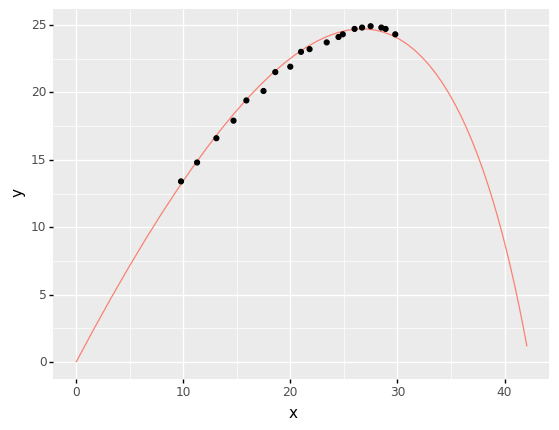

<ggplot: (8774011289902)>

In [14]:
df_traj_fit1 = gr.eval_df(
    md_traj_fit1,
    df=gr.df_make(t=np.linspace(0, 4.5))
)

(
    df_traj_fit1
    >> ggplot(aes("x", "y"))
    + geom_line(color="salmon")
    + geom_point(data=df_trajectory_windowed)
)


This looks far more reasonable!


## Coda: Ground-truth penny data

---


tau_true = 29.11843925165611


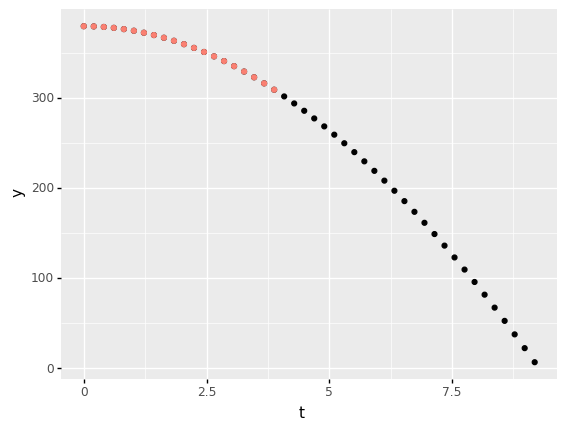

<ggplot: (8774011164820)>

In [15]:
g = 9.8 # Acceleration due to gravity, m/s^2

# Penny properties
Cd = 0.5    # Drag coefficient
rho = 1.205 # Density of air at STP, kg / m^3
A = 2.85e-4 # Cross-sectional area
m = 2.5e-3 # Mass of penny

# Stokes constant mu = 1 / tau
tau = (2 * m) / (Cd * rho * A)
print("tau_true = {}".format(tau))

# Trajectory with stokes drag
md_penny_true = (
    gr.Model("Penny: Ground-truth")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=df.y0 - g * tau * df.t + tau * (df.v0 + g * tau) * (1 - np.exp(-df.t / tau))
        ),
        var=["t", "v0", "y0"],
        out=["y"]
    )
)

# Generate some data
df_penny_true = (
    md_penny_true
    >> gr.ev_df(df=gr.df_make(v0=0, y0=380, t=np.linspace(0, 10, num=50)))
    >> gr.tf_filter(DF.y > 0)
)

# Save the first half of the data
df_penny_meas = df_penny_true.iloc[:20][["t", "y"]]
df_penny_meas.to_csv("./data/penny.csv", index=False)

# Visualize to check
(
    df_penny_true
    >> ggplot(aes("t", "y"))
    + geom_point()
    + geom_point(
        data=df_penny_meas,
        color="salmon"
    )
)